In [134]:
import sys
import os
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# FUNCTIONS

#defining the function to remove punctuation
def clean_text(text):
    punctuationfree="".join([i.lower() for i in text if i not in string.punctuation])
    return punctuationfree

import re
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens

def tokenize(text):
    tokens = text.split()
    # truncate if necessary
    if len(tokens) > 100:
        tokens = tokens[:100]
    return tokens

# creates word2vec model and returns list of word-vector embeddings
# sentences should be a list of lists of tokenized
def load_word_vectors(sentences):
    model = Word2Vec(sentences, size=100, window=5, min_count=1, workers=4)
    word_vectors = model.wv
    return word_vectors

def build_vocab(corpus):
    word_count = {}
    for sentence in corpus:
        for token in sentence:
            if token not in word_count:
                word_count[token] = 1
            else:
                word_count[token] += 1
    return word_count

def word2index(vocab):
    word_index = {w: i for i, w in enumerate(vocab)}
    idx_word = {i: w for i, w in enumerate(vocab)}
    return word_index, idx_word


def cosine_sim(a,b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim


In [4]:
class SentencePairs(Dataset):
    
    def __init__(self, file, transform=None):
        self.data = pd.read_pickle(file)

        s1_tokens = self.data['s1_tokens']
        s2_tokens = self.data['s2_tokens']
        corpus = s1_tokens + s2_tokens

        self.transform = transform
        self.vocab = self.build_vocab(corpus)
        self.word2idx, self.idx2word = self.word2index(self.vocab)
        self.idx2vec = self.index2vec(self.vocab)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # get input sentences
        tokens1 = self.data['s1_tokens'].values[idx]
        tokens2 = self.data['s2_tokens'].values[idx]
        # convert words to index

        input1 = [self.word2idx[word] for word in tokens1]
        input2 = [self.word2idx[word] for word in tokens2]
        # get label
        label = self.data['bin_label'].values[idx]

        mat1 = [self.idx2vec[i] for i in input1]
        mat2 = [self.idx2vec[i] for i in input2]

        # build sample
        sentence1 = torch.tensor(np.array(mat1))
        sentence2 = torch.tensor(np.array(mat2))
        label = torch.tensor(np.array(label))
        
        # add padding, since max sequence length is 100, matrices should be 100x100
        pad1 = 100-sentence1.shape[0]
        pad2 = 100-sentence2.shape[0]
        sentence1 = F.pad(sentence1, (0,0,0,pad1))
        sentence2 = F.pad(sentence2, (0,0,0,pad2))

        return (sentence1, sentence2), label

    def build_vocab(self, corpus):
        word_count = {}
        for sentence in corpus:

            for token in sentence:
                # print(token)
                if token not in word_count:
                    word_count[token] = 1
                else:
                    word_count[token] += 1
        return word_count

    def word2index(self, vocab):
        word_index = {w: i for i, w in enumerate(vocab)}
        idx_word = {i: w for i, w in enumerate(vocab)}
        return word_index, idx_word
     
    def index2vec(self, vocab):
         word_index = {w: i for i, w in enumerate(vocab)}
         vec_index = {i: word_vectors[w] for i, w in enumerate(vocab)}
         return vec_index

In [214]:
class Network(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size):
        super(Network, self).__init__()
        self.batch_size = batch_size
        self.layer_dim = 1
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        #self.cnn = nn.Sequential(
        #    # input: 100x100
        #    # output: 38x38x2
        #    nn.Conv2d(in_channels = 1, out_channels = n, kernel_size = 25, stride = 2),
        #    nn.Tanh(),
        #    # input: 38x38x2
        #    # output: 15x15x2
        #    nn.MaxPool2d(kernel_size = 10, stride = 2)
        # )

        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=hidden_dim, num_layers=self.layer_dim, batch_first=True)
        self.cos = nn.CosineSimilarity(dim=1)
        self.fc1 = nn.Linear(self.input_dim, self.input_dim)
        self.fc2 = nn.Linear(self.batch_size, 2)

    def forward(self, x1, x2):
 
        # LSTM
        h0 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)  
        c0 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        #print(x1.shape)
        rnn_out1, (hn1, cn1) = self.lstm(x1, (h0, c0))
        rnn_out2, (hn2, cn2) = self.lstm(x2, (h0, c0))
        #print(rnn_out1.shape)
        # linear
        dense1 = torch.relu(self.fc1(rnn_out1.squeeze()))
        dense2 = torch.relu(self.fc1(rnn_out2.squeeze()))
        #print(dense1.shape)
        # compute distance
        sim = self.cos(dense1, dense2)
        
        # Treat cosine similarity as probability of being paraphrase. But since this can output negative values, activate with ReLU to make them zero.
        # to address floating point errors, clamp outputs that are greater than 1
        out = torch.clamp(torch.relu(sim), min = 0, max = 1)

        return out
        #rnn_out1 = rnn_out1[:, -1, :].squeeze()
        #rnn_out2 = rnn_out2[:, -1, :].squeeze()
        
        # return out


In [7]:
corpus_dir = "/content/drive/MyDrive/Corpus"
twitter_train = os.path.join(corpus_dir, "Twitter_URL_Corpus_train.txt")

# read as tsv
data = pd.read_csv(twitter_train, sep = "\t", names = ['s1', 's2', 'label', 'url'])

In [8]:
# clean text
data['s1_clean'] = data['s1'].apply(lambda x: clean_text(x))
data['s2_clean'] = data['s2'].apply(lambda x: clean_text(x))

# tokenize
data['s1_tokens'] = data['s1_clean'].apply(lambda x: tokenize(x))
data['s2_tokens'] = data['s2_clean'].apply(lambda x: tokenize(x))

# create binary labels, ignoring 3,6 since these are inconclusive
data = data[data.label != "(3,6)"]
data['bin_label'] = data['label'].apply(lambda x: 0 if x in ['(0,6)', '(1,6)', '(2,6)'] else 1)

# save to csv
data.to_pickle('twitter_corpus_clean.pkl')

# TODO: clean/save test data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
# TODO: 
# Load csv
data = pd.read_pickle('twitter_corpus_clean.pkl')
# Create vectorized data
# Create data loader

# compile list of all tokenized sentences
s1_tokens = data['s1_tokens'].values.tolist()
s2_tokens = data['s2_tokens'].values.tolist()
sentence_lists = s1_tokens + s2_tokens

# create word_vectors list
# vectorized_word = word_vectors[word], can also use list of words
word_vectors = load_word_vectors(sentence_lists)



In [10]:
mydataset = SentencePairs(file = 'twitter_corpus_clean.pkl')

In [129]:
# create DataLoader
BATCH_SIZE = 10

train_data, val_data = torch.utils.data.random_split(mydataset, 
                                [math.floor(len(mydataset)*0.8), 
                                math.floor(len(mydataset)*0.2)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 100, shuffle = True)

In [215]:
# Train
device = 'cuda'

model = Network(input_dim = 100, hidden_dim = 1, batch_size = 10)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()
log_interval = 100
train_counter = 0
train_step = []
train_loss = []
val_step = []
val_loss = []
val_acc = []
verbose=True
epochs = 10
total_batches = len(train_loader)
train_batch_size = 10
val_batch_size = 100
for epoch in range(epochs):
    for batch, (data, targets) in enumerate(train_loader):
        train_counter += 1

        # reshape so batch size is first dim
        input1 = data[0].to(device)
        input2 = data[1].to(device)
        model.train()
        
        optimizer.zero_grad()
        output = model(input1, input2)
        
        loss = loss_fn(output.squeeze().cpu(), targets.float().T) 
        loss.backward()
        optimizer.step()

        if (batch % log_interval == 0):
            train_step.append(train_counter)
            train_loss.append(loss.item())
            if (verbose):
                print(f'Epoch: {epoch+1}, Batch: {batch}/{total_batches}, Loss: {loss.item()}')
        
    # validate model at the end of each epoch
    val_step.append(train_counter)
    val_loss_tmp = []
    val_acc_tmp = []
    for batch, (val_data, val_targets) in enumerate(val_loader):
        model.eval()
    
        with torch.no_grad():
            input1 = val_data[0].to(device)
            input2 = val_data[1].to(device)
            val_output = model(input1, input2)
            loss = loss_fn(val_output.squeeze().cpu(), val_targets.float().T)
            val_loss_tmp.append(loss.item())
            correct = (torch.round(val_output.detach().cpu().T) == val_targets).type(torch.FloatTensor)
            val_acc_tmp.append(correct.mean())

    val_loss.append(np.mean(val_loss_tmp))
    val_acc.append(np.mean(val_acc_tmp))

Epoch: 1, Batch: 0/3376, Loss: 2.1900956630706787
Epoch: 1, Batch: 100/3376, Loss: 0.6164368987083435
Epoch: 1, Batch: 200/3376, Loss: 0.5353736281394958
Epoch: 1, Batch: 300/3376, Loss: 0.9007205963134766
Epoch: 1, Batch: 400/3376, Loss: 0.34103548526763916
Epoch: 1, Batch: 500/3376, Loss: 0.6439110636711121
Epoch: 1, Batch: 600/3376, Loss: 0.46878036856651306
Epoch: 1, Batch: 700/3376, Loss: 0.7147356271743774
Epoch: 1, Batch: 800/3376, Loss: 0.5710707902908325
Epoch: 1, Batch: 900/3376, Loss: 0.6716331243515015
Epoch: 1, Batch: 1000/3376, Loss: 0.9265871047973633
Epoch: 1, Batch: 1100/3376, Loss: 0.5473144054412842
Epoch: 1, Batch: 1200/3376, Loss: 0.23965144157409668
Epoch: 1, Batch: 1300/3376, Loss: 0.5675174593925476
Epoch: 1, Batch: 1400/3376, Loss: 0.7344686388969421
Epoch: 1, Batch: 1500/3376, Loss: 0.5840467214584351
Epoch: 1, Batch: 1600/3376, Loss: 0.5407580137252808
Epoch: 1, Batch: 1700/3376, Loss: 0.7968915104866028
Epoch: 1, Batch: 1800/3376, Loss: 0.7953397631645203
Ep

In [212]:
output

tensor([0.9287, 0.7545, 0.7698, 0.7959, 0.8959, 0.7793, 0.8364, 0.6207, 0.6203,
        0.6858], requires_grad=True)

In [197]:
loss_fn(output.squeeze().cpu(), targets.float().T) 

tensor(0.6764, grad_fn=<BinaryCrossEntropyBackward0>)

Text(0, 0.5, '% Correct')

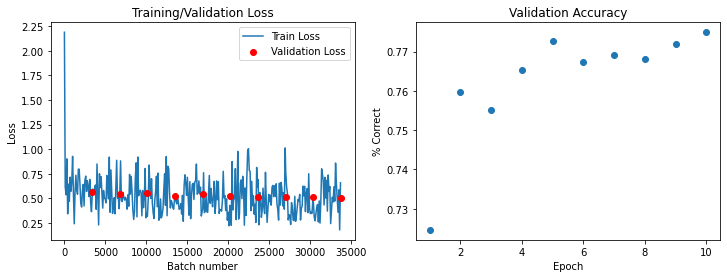

In [216]:
# output loss and accuracy
%matplotlib inline
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.scatter(val_step, val_loss, c="Red", zorder = 1);
plt.plot(train_step, train_loss, zorder = -1);
plt.title("Training/Validation Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.legend(['Train Loss', 'Validation Loss']);
plt.subplot(122)
plt.scatter(np.arange(start=1,stop=len(val_acc)+1), val_acc);
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("% Correct")
